In [5]:
import json
import os
import requests
import pandas as pd
import pymongo.errors
import plotly.express as px
import uuid
import random
from bs4 import BeautifulSoup
from io import StringIO
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

## Setup

### MongoDB 

In [6]:
# read
with open("../../.nosync/mongoDB.json", "r") as file:
    credentials = json.load(file)

uri = (
    "mongodb+srv://medvetslos:"
    + json.load(open("../../.nosync/mongoDB.json"))["pwd"]
    + "@ind320-project.lunku.mongodb.net/?retryWrites=true&w=majority&appName=IND320-project"
)

mdb_client = MongoClient(uri, server_api=ServerApi("1"))

try:
    mdb_client.admin.command("ping")
    print("Pinged your deployment. Successfully connected to MongoDB.")
except Exception as exceptionMsg:
    print(exceptionMsg)

Pinged your deployment. Successfully connected to MongoDB.


In [7]:
# Creating collections for municipality data and gas prices
database = mdb_client["IND320-project"]
collection_names = ["municipalities", "gas"]

for name in collection_names:
    # Checking if collection exists. If not, create the collection.
    try:
        database.create_collection(name)
        print(f"Collection '{name}' was created successfully.")
    except pymongo.errors.CollectionInvalid:
        print(f"Collection '{name}' already exists.")

municipalities_collection = database[collection_names[0]]
gas_collection = database[collection_names[1]]


Collection 'municipalities' already exists.
Collection 'gas' was created successfully.


### Cassandra

In [4]:
# Set environment variables
os.environ["JAVA_HOME"] = "/opt/homebrew/opt/openjdk@11/"
os.environ["PYSPARK_PYTHON"] = "python" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "python" 
os.environ["PYSPARK_HADOOP_VERSION"] = "without"

In [5]:
# Spark set up
spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').\
    config("spark.driver.memory", "4g").\
    config("spark.executor.memory", "4g").\
    config("spark.task.maxFailures", "10").\
    config("spark.sql.shuffle.partitions", "200").\
    getOrCreate()

24/10/11 13:47:05 WARN Utils: Your hostname, Aarons-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.11.132 instead (on interface en0)
24/10/11 13:47:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /Users/aaron/.ivy2/cache
The jars for the packages stored in: /Users/aaron/.ivy2/jars
com.datastax.spark#spark-cassandra-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c4313539-4548-4eb1-a942-377036ba56c9;1.0
	confs: [default]


:: loading settings :: url = jar:file:/Users/aaron/Documents/IND320_projects/.venv/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found com.datastax.spark#spark-cassandra-connector_2.12;3.4.1 in central
	found com.datastax.spark#spark-cassandra-connector-driver_2.12;3.4.1 in central
	found org.scala-lang.modules#scala-collection-compat_2.12;2.11.0 in central
	found com.datastax.oss#java-driver-core-shaded;4.13.0 in central
	found com.datastax.oss#native-protocol;1.5.0 in central
	found com.datastax.oss#java-driver-shaded-guava;25.1-jre-graal-sub-1 in central
	found com.typesafe#config;1.4.1 in central
	found org.slf4j#slf4j-api;1.7.26 in central
	found io.dropwizard.metrics#metrics-core;4.1.18 in central
	found org.hdrhistogram#HdrHistogram;2.1.12 in central
	found org.reactivestreams#reactive-streams;1.0.3 in central
	found com.github.stephenc.jcip#jcip-annotations;1.0-1 in central
	found com.github.spotbugs#spotbugs-annotations;3.1.12 in central
	found com.google.code.findbugs#jsr305;3.0.2 in central
	found com.datastax.oss#java-driver-mapper-runtime;4.13.0 in central
	found com.datastax.oss#java-driver-query-

In [6]:
from cassandra.cluster import Cluster

cluster = Cluster(["localhost"], port=9042)
session = cluster.connect()
keyspace = "ind320_project"

# Creating a keyspace in Cassandra
session.execute(
    "CREATE KEYSPACE IF NOT EXISTS" + 
    " " + 
    keyspace + 
    " " + 
    "WITH REPLICATION = {'class': 'SimpleStrategy', 'replication_factor': 1};"
)

session.set_keyspace(keyspace)

## Webscraping



In [7]:
# Webscraping, retrieving the table from the Wikipedia page
webscrape_url = "https://en.wikipedia.org/wiki/List_of_municipalities_of_Denmark"
page = requests.get(webscrape_url)
soup = BeautifulSoup(page.content, "html.parser")
wiki_table = soup.find("table", attrs={"class": "wikitable sortable"})

df_municipalities = pd.read_html(StringIO(str(wiki_table)))[0]
records_municipalities = df_municipalities.to_dict("records")

LAU_1_code = df_municipalities.columns.tolist()[0]

# Prompt: Write a check to see if we're inserting data which already exists
#         in a MongoDB collection

# check if data we are writing already exists
existing_entries = list(
    municipalities_collection.find(
        {
            LAU_1_code: {"$in": [record[LAU_1_code] for record in records_municipalities]}
        }
    )
)

# if new data,
new_entries = [
    entry for entry in records_municipalities
    if not any(existing_entry[LAU_1_code] == entry[LAU_1_code] for existing_entry in existing_entries)
]

# Writing to MongoDB
if len(new_entries) > 0:
    municipalities_collection.insert_many(new_entries)
    print("Data successfully written into the collection.")
else:
    print("No new data to be inserted into the collection.")

Data successfully written into the collection.


## API

In [8]:
# Setting up for data retrieval with the API

api_url = "https://api.energidataservice.dk/dataset/"
filtering = "?offset=0&start=2022-01-01T00:00&end=2023-01-01T00:00"

api_datasets = {
    "remote": {"gas": "GasDailyBalancingPrice"},
    "local": {
         "production": "ProductionMunicipalityHour", 
         "consumption": "ConsumptionIndustry",
         "prodcons": "ProductionConsumptionSettlement"
    }
}

def get_json_data(dataset: str):
    return requests.get(api_url + dataset + filtering).json()["records"]

### Retrieval and insertion to MongoDB

In [9]:
# Retrieve data from API and insert it into MongoDB collection
df_gas = pd.DataFrame.from_records(get_json_data(api_datasets["remote"]["gas"]))
df_gas["GasDay"] = pd.to_datetime(df_gas["GasDay"])
gas_data = df_gas.to_dict("records")
database["gas"].insert_many(gas_data)

InsertManyResult([ObjectId('6732429db2181cbdd478fd1d'), ObjectId('6732429db2181cbdd478fd1e'), ObjectId('6732429db2181cbdd478fd1f'), ObjectId('6732429db2181cbdd478fd20'), ObjectId('6732429db2181cbdd478fd21'), ObjectId('6732429db2181cbdd478fd22'), ObjectId('6732429db2181cbdd478fd23'), ObjectId('6732429db2181cbdd478fd24'), ObjectId('6732429db2181cbdd478fd25'), ObjectId('6732429db2181cbdd478fd26'), ObjectId('6732429db2181cbdd478fd27'), ObjectId('6732429db2181cbdd478fd28'), ObjectId('6732429db2181cbdd478fd29'), ObjectId('6732429db2181cbdd478fd2a'), ObjectId('6732429db2181cbdd478fd2b'), ObjectId('6732429db2181cbdd478fd2c'), ObjectId('6732429db2181cbdd478fd2d'), ObjectId('6732429db2181cbdd478fd2e'), ObjectId('6732429db2181cbdd478fd2f'), ObjectId('6732429db2181cbdd478fd30'), ObjectId('6732429db2181cbdd478fd31'), ObjectId('6732429db2181cbdd478fd32'), ObjectId('6732429db2181cbdd478fd33'), ObjectId('6732429db2181cbdd478fd34'), ObjectId('6732429db2181cbdd478fd35'), ObjectId('6732429db2181cbdd478fd

### Retrieval for Cassandra

In [10]:
# Retrieve the data from the API
df_production = pd.DataFrame.from_records(get_json_data(api_datasets["local"]["production"]))
df_consumption = pd.DataFrame.from_records(get_json_data(api_datasets["local"]["consumption"]))
df_prodcons = pd.DataFrame.from_records(get_json_data(api_datasets["local"]["prodcons"]))

In [11]:
# Converting various columns of the data frames to appropriate data types 
df_production['HourDK'] = pd.to_datetime(df_production['HourDK'])
df_production['HourUTC'] = pd.to_datetime(df_production['HourUTC'])
df_production['MunicipalityNo'] = df_production['MunicipalityNo'].astype(int)

df_consumption['HourDK'] = pd.to_datetime(df_consumption['HourDK'])
df_consumption['HourUTC'] = pd.to_datetime(df_consumption['HourUTC'])
df_consumption['MunicipalityNo'] = df_consumption['MunicipalityNo'].astype(int)
df_consumption['Branche'] = df_consumption['Branche'].astype(str)

df_prodcons['HourDK'] = pd.to_datetime(df_prodcons['HourDK'])
df_prodcons['HourUTC'] = pd.to_datetime(df_prodcons['HourUTC'])
df_prodcons['PriceArea'] = df_prodcons['PriceArea'].astype(str)
df_prodcons['ExchangeGB_MWh'] = df_prodcons["ExchangeGB_MWh"].astype(float)

# Have to set column names to lowercase to be able to write through PySpark
df_prodcons = df_prodcons.rename(columns=str.lower)
df_production = df_production.rename(columns=str.lower)
df_consumption = df_consumption.rename(columns=str.lower)

In [12]:
# Prompt: Can you write me a function which makes the table creation query from a 
#         Pandas DataFrame which assigns the correct datatype to the Cassandra table.
#         The primary key should be named id and be of type timeuuid

def create_cassandra_table_query(df, keyspace, table_name):
    # Define mapping between Pandas and Cassandra datatypes
    dtype_mapping = {
        'int64': 'int',
        'float64': 'double',
        'object': 'text',
        'bool': 'boolean',
        'datetime64[ns]': 'timestamp'
    }
    
    # Start constructing the CREATE TABLE query
    query = f"CREATE TABLE IF NOT EXISTS {keyspace}.{table_name} (\n"
    
    # Add primary key column with timeuuid
    columns = ["id timeuuid"]
    
    # Add remaining columns with mapped Cassandra data types
    for col, dtype in df.dtypes.items():
        if col != "id":  # Exclude 'id' to avoid duplication
            cassandra_type = dtype_mapping.get(str(dtype), 'text')  # Default to 'text' if type is unrecognized
            columns.append(f"{col} {cassandra_type}")
    
    # Join columns with commas and specify primary key as 'id'
    columns_str = ",\n    ".join(columns)
    query += f"    {columns_str},\n"
    query += "    PRIMARY KEY (id)\n);"
    
    return query

# Creating the query for the tables 
production_table = create_cassandra_table_query(df_production, keyspace, "production")
consumption_table = create_cassandra_table_query(df_consumption, keyspace, "consumption") 
prodcons_table = create_cassandra_table_query(df_prodcons, keyspace, "prodcons") 

# Creating the tables with the queries made above
for table_query in [production_table, consumption_table, prodcons_table]:
    session.execute(table_query)

In [13]:
# Verifying that the tables have been created 
query = f"SELECT table_name FROM system_schema.tables WHERE keyspace_name = '{keyspace}'"
rows = session.execute(query)
print(f"Tables in keyspace '{keyspace}':")
for row in rows:
    print(row.table_name)

Tables in keyspace 'ind320_project':
consumption
prodcons
production


### Insertion to Cassandra with Spark

In [14]:
# Making a function to insert into a Cassandra table
def insert_to_cas(df: pd.DataFrame , table_name: str, keyspace_name: str): 
# Prompt: How can I add a timeuuid 'id' column when inserting into Cassandra with PySpark
    def generate_timeuuid():
        return str(uuid.uuid1())
    
    timeuuid_udf = udf(generate_timeuuid, StringType())
    spark.createDataFrame(df).withColumn("id", timeuuid_udf())\
        .write.format("org.apache.spark.sql.cassandra")\
        .mode("append")\
        .options(table=table_name, keyspace=keyspace_name)\
        .save()
    
# Inserting the Pandas data frame into Cassandra with Spark 
insert_to_cas(df_production, "production", "ind320_project")
insert_to_cas(df_consumption, "consumption", "ind320_project")
insert_to_cas(df_prodcons, "prodcons", "ind320_project")

24/10/11 13:48:22 WARN TaskSetManager: Stage 0 contains a task of very large size (5307 KiB). The maximum recommended task size is 1000 KiB.
24/10/11 13:49:26 WARN TaskSetManager: Stage 1 contains a task of very large size (9911 KiB). The maximum recommended task size is 1000 KiB.
24/10/11 13:50:27 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Plotting

### Energy exchange to Norway

In [15]:
# Function to create a view to retrieve data from Cassandra
def create_view_from_cas(view_name:str, table_name: str, keyspace_name: str):
    spark.read.format("org.apache.spark.sql.cassandra")\
        .options(table=table_name, keyspace=keyspace_name)\
        .load()\
        .createOrReplaceTempView(view_name)
    print(f"View '{view_name}' created.")

View 'prodcons_view' created.


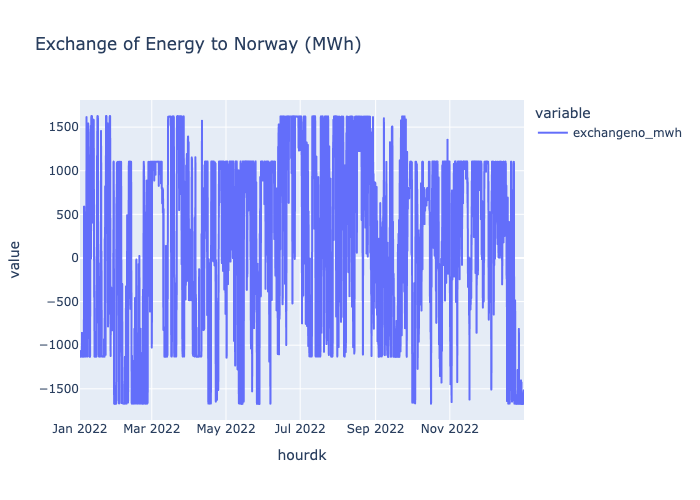

In [16]:
# Create a view so we can retrieve from Cassandra
create_view_from_cas("prodcons_view", "prodcons", keyspace)

sdf_prodcons = spark.sql("SELECT * FROM prodcons_view").toPandas()
sdf_prodcons = sdf_prodcons.sort_values(by="hourdk", ascending=True)
df_exchangeno = sdf_prodcons[["hourdk", "exchangeno_mwh"]].copy()
df_exchangeno_agg = df_exchangeno.groupby("hourdk").aggregate({"exchangeno_mwh": "sum"}) # Need to aggregate and sum to get the exchange of energy
exchangeNo_fig = px.line(df_exchangeno_agg, title = "Exchange of Energy to Norway (MWh)")
exchangeNo_fig.show(renderer="png")

### Sales and purchase prices of gas

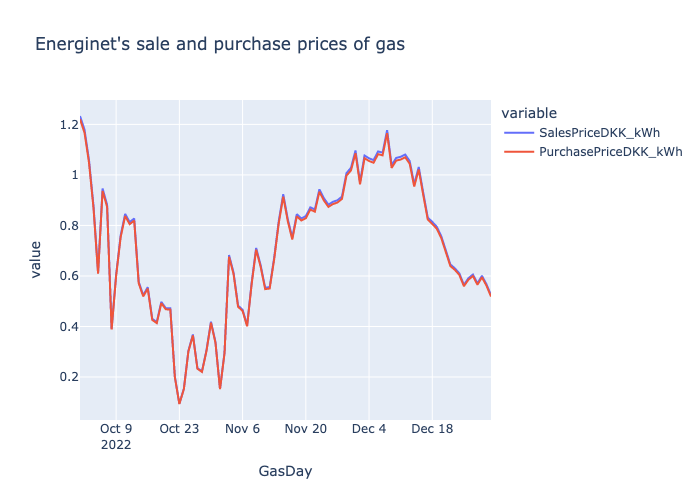

In [17]:
gas = database["gas"] # Retrieve data from MongoDB collection
gas_records = [document for document in gas.find()]
df_gas = pd.DataFrame.from_records(gas_records)
df_gas = df_gas.sort_values("GasDay", ascending=True)

price_fig = px.line(df_gas, x="GasDay", y=["SalesPriceDKK_kWh", "PurchasePriceDKK_kWh"], 
                    title="Energinet's sale and purchase prices of gas")
price_fig.show(renderer="png")

### Production, consumption and production/consumption

In [18]:
create_view_from_cas("production_view", "production", keyspace)
production = spark.sql("SELECT * FROM production_view").toPandas()
production = production.sort_values("hourdk", ascending=True) # Sort w.r.t. time so we can plot properly

View 'production_view' created.


In [19]:
create_view_from_cas("consumption_view", "consumption", keyspace)
consumption = spark.sql("SELECT * FROM consumption_view").toPandas()
consumption = consumption.sort_values("hourdk", ascending=True) # Sort w.r.t. time so we can plot properly

View 'consumption_view' created.


In [20]:
create_view_from_cas("prodcons_view", "prodcons", keyspace)
prodcons = spark.sql("SELECT * FROM prodcons_view").toPandas()

# Removing non-production related columns
prodcons = prodcons[[
    'id', 'centralpowermwh', 'commercialpowermwh', 
    # 'exchangegb_mwh','exchangege_mwh', 'exchangegreatbelt_mwh', 
    # 'exchangenl_mwh', 'exchangeno_mwh', 'exchangese_mwh', 
    # 'gridlossdistributionmwh', 'gridlossinterconnectorsmwh', 'gridlosstransmissionmwh',
    # 'grossconsumptionmwh', 
    'hourdk', 'hourutc', 
    'hydropowermwh',
    'localpowermwh', 
    'localpowerselfconmwh', 'offshorewindge100mw_mwh',
    'offshorewindlt100mw_mwh', 'onshorewindge50kw_mwh',
    'onshorewindlt50kw_mwh', 
    # 'powertoheatmwh', 
    'pricearea',
    'solarpowerge10lt40kw_mwh', 'solarpowerge40kw_mwh',
    'solarpowerlt10kw_mwh', 'solarpowerselfconmwh', 'unknownprodmwh'
]].sort_values("hourdk", ascending=True)

View 'prodcons_view' created.


In [21]:
# Select a random relevant column of a data frame
def select_random_column(df):
    exclude_columns = ["hourdk", "pricearea", "municipalityno", "hourutc", "id"]
    columns = [col for col in df.columns if col not in exclude_columns]
    return random.choice(columns)

# Get the municipality name from its LAU-1 code 
def get_municipality_name(municipalityno):
    table_entry = municipalities_collection.find_one({"LAU-1 code 1": municipalityno})
    return table_entry["Municipality"]

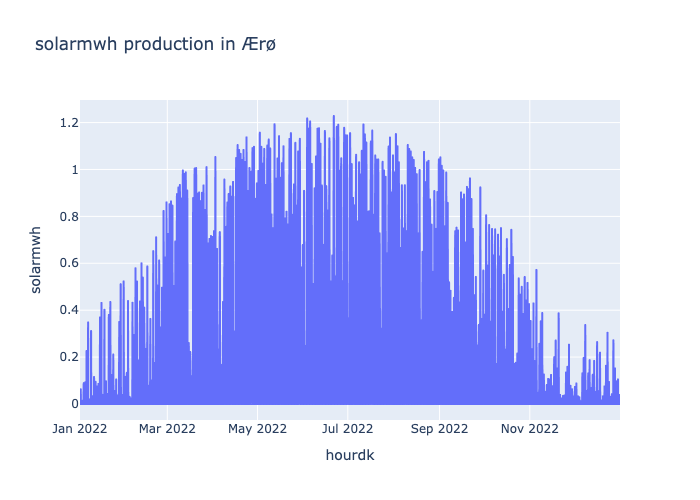

In [22]:
random.seed(1333)

# Choosing production type and municipality at random
rng_prod_type = select_random_column(production)
rng_prod_muni = random.choice(production["municipalityno"].unique())
rng_prod_muni_name = get_municipality_name(int(rng_prod_muni))

df_rng_prod = production.query(f"municipalityno == {rng_prod_muni}")
rng_prod_fig = px.line(df_rng_prod, x = 'hourdk', y = rng_prod_type,
                       title=f"{rng_prod_type} production in {rng_prod_muni_name}")

rng_prod_fig.show(renderer="png")

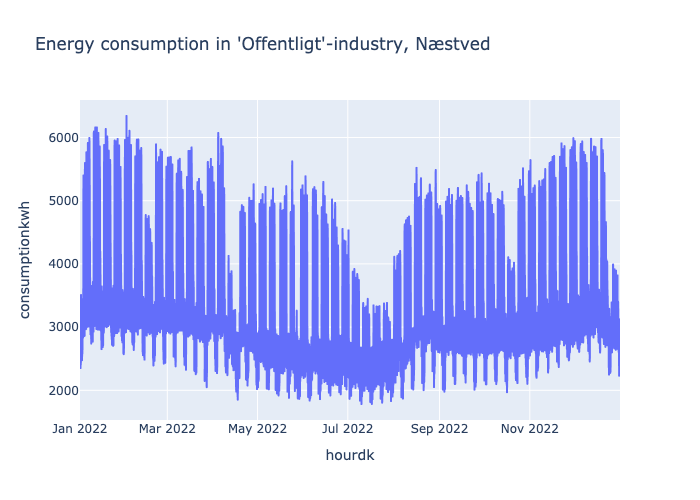

In [23]:
# Choosing branch and municipality at random
rng_cons_muni = random.choice(consumption["municipalityno"].unique())
rng_cons_branche = random.choice(consumption["branche"].unique())
rng_cons_muni_name = get_municipality_name(int(rng_cons_muni))

df_rng_cons = consumption.query(f"municipalityno == {rng_cons_muni} and branche == '{rng_cons_branche}'")
rng_cons_fig = px.line(df_rng_cons, x = 'hourdk', y = 'consumptionkwh',
                       title=f"Energy consumption in '{rng_cons_branche}'-industry, {rng_cons_muni_name}")

rng_cons_fig.show(renderer="png")

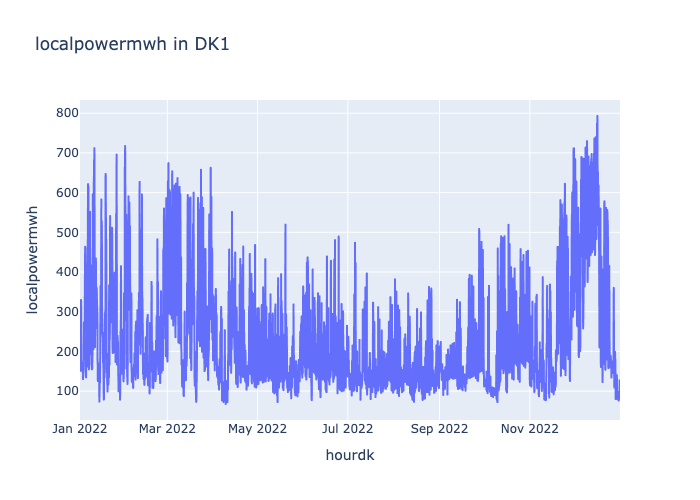

In [24]:
# Choosing production type and price area at random
rng_prodcons_type = select_random_column(prodcons)
rng_prodcons_price_area = random.choice(prodcons["pricearea"].unique())

df_rng_prodcons = prodcons.query(f"pricearea == '{rng_prodcons_price_area}'")
rng_prodcons_fig = px.line(df_rng_prodcons, x = 'hourdk', y = rng_prodcons_type,
                           title=f"{rng_prodcons_type} in {rng_prodcons_price_area}")
rng_prodcons_fig.show(renderer="png")